In [1]:
# Mount google drive

import json
import os
from google.colab import drive

drive.mount('/content/drive/')
os.chdir("/content/drive/MyDrive/dfdcDataset/dfdc_train_part_45")



Mounted at /content/drive/


In [2]:
# Filter data into real and fake

f = open('metadata.json', "r")

metadata = json.loads(f.read())
metadata = metadata
fakes = []
reals = []
for each in metadata.keys():
  if metadata[each]["label"] == "FAKE":
    fakes.append(each)
  else:
    reals.append(each)
fakes = fakes[:200]
reals = reals[:200]
print(len(fakes), len(reals))

200 200


In [3]:
import cv2
import tensorflow

def extract_frames(video_path, frame_rate):
    video = cv2.VideoCapture(video_path)
    fps = video.get(cv2.CAP_PROP_FPS)
    framesInterval = int(fps * frame_rate)
    count = 0
    frames = []
    while video.isOpened():
        ret, frame = video.read()
        if not ret:
            break
        if count % framesInterval == 0:
            frames.append(frame)
        count += 1
    video.release()
    return frames

realFrames = {}
fakeFrames = {}
for each in reals:
  realFrames[each] = extract_frames(each, 7)


for each in fakes:
  fakeFrames[each] = extract_frames(each, 7)


In [4]:
import numpy as np

def frames_to_dataset(frames_dict, label):
    X = []
    y = []
    for video_path, frames in frames_dict.items():
        for frame in frames:
            frame_resized = cv2.resize(frame, (299, 299))
            X.append(frame_resized)
            y.append(label)
    return np.array(X), np.array(y)

X_real, y_real = frames_to_dataset(realFrames, 0)
X_fake, y_fake = frames_to_dataset(fakeFrames, 1)

X_train = np.concatenate((X_real, X_fake), axis=0)
y_train = np.concatenate((y_real, y_fake), axis=0)

X_train = X_train.astype('float32') / 255.0


In [5]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train, random_state=0)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [6]:
from tensorflow.keras.models import load_model


model_1 = load_model('inceptionResNet.h5')
model_2 = load_model('DenseNet121.h5')


In [7]:
from tensorflow.keras.models import Model

model_1_features = Model(inputs=model_1.input, outputs=model_1.layers[-2].output)
model_2_features = Model(inputs=model_2.input, outputs=model_2.layers[-2].output)

In [8]:
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image

def extract_features(num, model, X, size):


    X_resized = np.array([image.img_to_array(Image.fromarray(img.astype('uint8')).resize((size, size))) for img in X])


    if num == "first":
        from keras.applications.inception_resnet_v2 import preprocess_input
    elif num == "second":
        from keras.applications.densenet import preprocess_input
    else:
        raise ValueError("Unsupported model")


    X_preprocessed = preprocess_input(X_resized)
    return model.predict(X_preprocessed)


model_1_features = extract_features("first", model_1, X_train, 299)
model_2_features = extract_features("second", model_2, X_train, 224)
print("done")

20/20 [==============================] - 103s 5s/step
done


In [16]:
import lightgbm as lgb

combined_features = np.concatenate([model_1_features, model_2_features], axis=1)


train_data = lgb.Dataset(combined_features, label=y_train)


params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    # 'num_leaves': 90,
    # 'learning_rate': 0.05,
    # 'feature_fraction': 0.9,
    # 'bagging_fraction': 0.8,
    # 'bagging_freq': 5,
    # 'verbose': 0
}




num_boost_round = 100
lgb_model = lgb.train(params, train_data, num_boost_round=num_boost_round)


[LightGBM] [Info] Number of positive: 316, number of negative: 324
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 428
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493750 -> initscore=-0.025001
[LightGBM] [Info] Start training from score -0.025001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [17]:

new_data_features = np.concatenate([
    model_1_features,
    model_2_features
], axis=1)


predictions = lgb_model.predict(new_data_features)


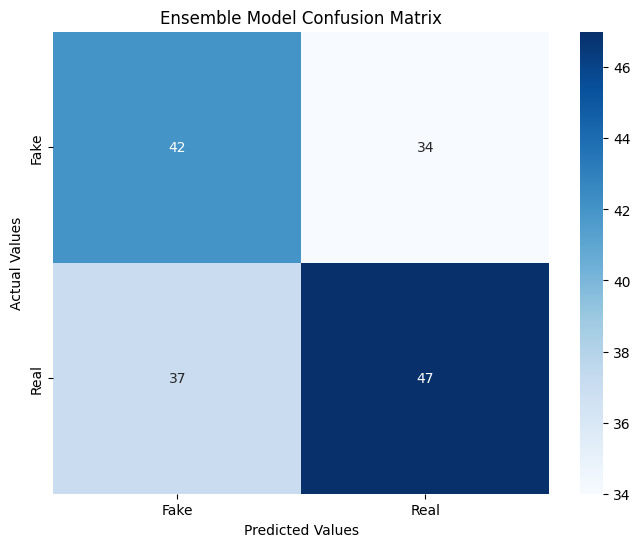

Accuracy: 0.55625
AUC-ROC: 0.556077694235589


In [20]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

predicted_labels = (predictions > 0.5).astype(int)

cm = confusion_matrix(y_val, predicted_labels[:160])


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Ensemble Model Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()


accuracy = accuracy_score(y_val, predicted_labels[:160])
print("Accuracy:", accuracy)


auc_roc = roc_auc_score(y_val, predicted_labels[:160])
print("AUC-ROC:", auc_roc)


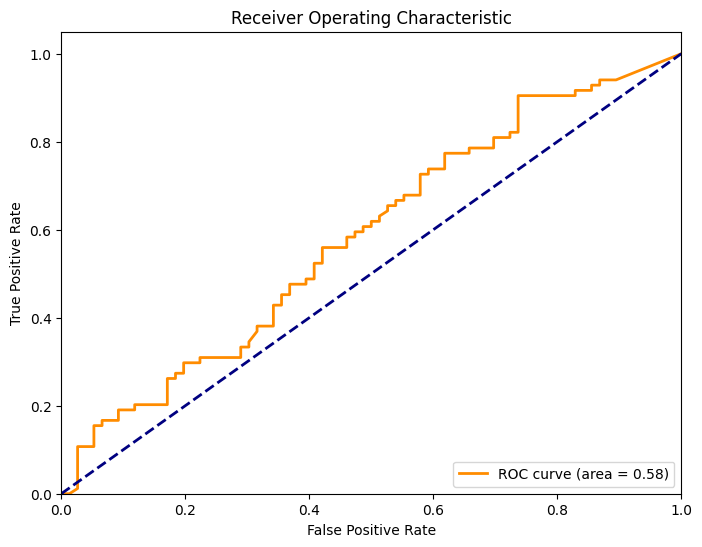

AUC-ROC: 0.5833333333333333


In [22]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


fpr, tpr, _ = roc_curve(y_val, predictions[:160])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC-ROC:", roc_auc)

In [24]:
from sklearn.metrics import accuracy_score, roc_auc_score
print(len(predicted_labels))
print(len(y_val))

predicted_labels = (predictions > 0.5).astype(int)
print("Accuracy:", accuracy_score(y_val, predicted_labels[:160]))
print("AUC-ROC:", roc_auc_score(y_val, predicted_labels[:160]))

640
160
Accuracy: 0.55625
AUC-ROC: 0.556077694235589


In [ ]:
# # Flatten the image data into two dimensions
# X_val_flattened = X_val.reshape(X_val.shape[0], -1)  # Reshape to (num_samples, features)
# print("Shape of X_val after flattening:", X_val_flattened.shape)

# # Now make predictions
# predictions = lgb_model.predict(X_val_flattened)
# predicted_labels = (predictions > 0.5).astype(int)

# # Calculate metrics
# print("Accuracy:", accuracy_score(y_val, predicted_labels))
# print("AUC-ROC:", roc_auc_score(y_val, predictions))



In [ ]:
# from sklearn.model_selection import train_test_split

# # Example of correctly splitting and predicting
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# # Assuming 'model' is your trained model
# predictions = lgb_model.predict(X_val)  # Generate predictions for validation set
# predicted_labels = (predictions > 0.5).astype(int)  # Convert probabilities to binary labels

# # Now check sizes again
# print("Validation labels size:", y_val.shape)
# print("Predictions size:", predicted_labels.shape)

# # Calculate metrics
# from sklearn.metrics import accuracy_score, roc_auc_score
# print("Accuracy:", accuracy_score(y_val, predicted_labels))
# print("AUC-ROC:", roc_auc_score(y_val, predictions))


In [ ]:
# import lightgbm as lgb

# # Load models
# model_1 = lgb.Booster(model_file='inceptionResNet.h5')
# model_2 = lgb.Booster(model_file='DenseNet121.h5')


# # Predict using both models
# preds_1 = model_1.predict(X_val)
# preds_2 = model_2.predict(X_val)

# final_preds = (preds_1 + preds_2) / 2
# # Example weights: 60% for model_1, 40% for model_2
# final_preds = 0.6 * preds_1 + 0.4 * preds_2
# from sklearn.metrics import accuracy_score, roc_auc_score

# # Assume y_test are the true labels
# accuracy = accuracy_score(y_test, final_preds.round())  # For classification
# auc_score = roc_auc_score(y_test, final_preds)          # For binary classification

# print(f'Accuracy: {accuracy}, AUC: {auc_score}')

